# MLP applied to quantum metrology

Here I will show how we used MLP to infer a probability distribution of the laser detunning

In [1]:
"Code imports"
import tensorflow as tf 
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy import loadtxt
from numpy import savetxt
from scipy.sparse.linalg import expm, expm_multiply
from scipy import sparse

In [3]:
"Now we import and preprocess the registers"
"We import the registers"
n_Delta=100 
Delta_vec=np.linspace(1,5,n_Delta)

Delta_class=list(range(n_Delta))


diccionario_clases=dict(zip(Delta_vec,Delta_class))




out_name = "C:/Users/Manuel/Desktop/universidad/beca_gefes_2021/proyecto/archivos_clicks/n_Delta_100_n_clicks_100/clicks_deltas_Omega_3.csv"

Deltas_and_clicks=loadtxt(out_name,delimiter=",")


y_full=Deltas_and_clicks[:,0] 
y_full_class=np.vectorize(diccionario_clases.get)(y_full)
X_full=Deltas_and_clicks[:,1:] 

"We are only interested in the time difference between photons"
X_full[:,1:]=X_full[:,1:]-X_full[:,:-1]



ratio=0.8
limit=int(ratio*len(y_full))
y_train,y_valid=y_full_class[:limit],y_full_class[limit:]

"We reescale the photon times so that the inputs are between 0 and 1 as it is in that range where we have"
"the most expresivity of the activation functions"
maxX=np.amax(X_full)
X_train,X_valid=X_full[:limit,:]/maxX,X_full[limit:,:]/maxX



In [4]:
"We train our first neural network, with early stopping so that we retrive the best weights"
es = EarlyStopping(monitor='val_loss', 
                       mode='min', verbose=1, patience=10, min_delta=0.01, 
                       restore_best_weights=True)

model=keras.models.Sequential([
 
    keras.layers.Dense(300,activation="relu"),
    keras.layers.Dense(100,activation="relu"),
    keras.layers.Dense(100,activation="relu"),
    keras.layers.Dense(n_Delta,activation="softmax")

    # El activador es softmax para que salga una distribucion normalizada


    ])
model.compile(loss="sparse_categorical_crossentropy", 
                                optimizer="adam",metrics=["accuracy"])
model.fit( X_train, y_train, epochs = 50,
                            validation_data = (X_valid, y_valid), 
                            callbacks = [es])

Epoch 1/50
2500/2500 [==============================] - 7s 3ms/step - loss: 3.8914 - accuracy: 0.0332 - val_loss: 3.8510 - val_accuracy: 0.0329
Epoch 2/50
2500/2500 [==============================] - 7s 3ms/step - loss: 3.7876 - accuracy: 0.0374 - val_loss: 3.7847 - val_accuracy: 0.0388
Epoch 3/50
2500/2500 [==============================] - 7s 3ms/step - loss: 3.7779 - accuracy: 0.0359 - val_loss: 3.7768 - val_accuracy: 0.0354
Epoch 4/50
2500/2500 [==============================] - 7s 3ms/step - loss: 3.7688 - accuracy: 0.0383 - val_loss: 3.7806 - val_accuracy: 0.0369
Epoch 5/50
2500/2500 [==============================] - 7s 3ms/step - loss: 3.7617 - accuracy: 0.0383 - val_loss: 3.7672 - val_accuracy: 0.0402
Epoch 6/50
2500/2500 [==============================] - 7s 3ms/step - loss: 3.7500 - accuracy: 0.0398 - val_loss: 3.7952 - val_accuracy: 0.0376
Epoch 7/50
2500/2500 [==============================] - 7s 3ms/step - loss: 3.7400 - accuracy: 0.0410 - val_loss: 3.7775 - val_accuracy:

The Early Stopping callback saves us from the overfitting problem. We use sparse categorical crossentropy
instead of categorical crossentropy because of the representation of delta's used. We could just do one hot encoding
and apply categorical crossentropy but we chose not.

Now I will plot a few probability distributions and the delta used to make the simulations. Please note that since this
is a stochastic process the delta simulated doesn't have to coincide with the maximum of the probability function, but 
should be reasonably close.

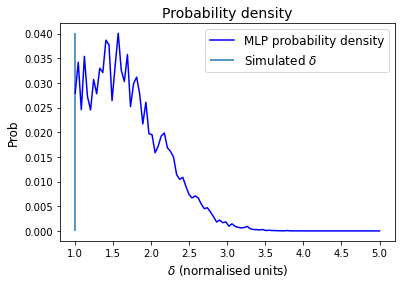

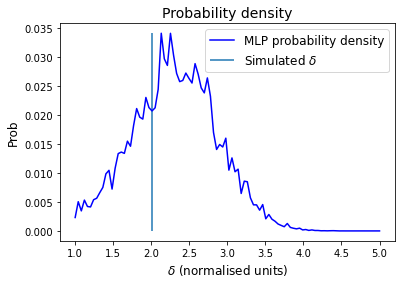

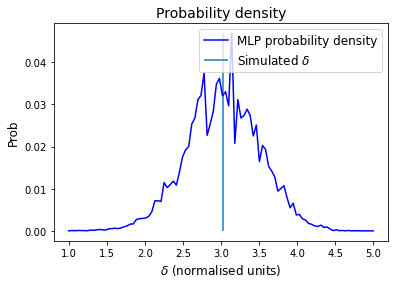

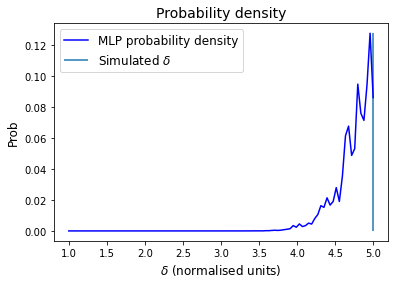

In [6]:
y_pred = model.predict(X_valid)

for i in [0,25,50,99]:
    plt.figure()
    plt.plot(Delta_vec, y_pred[i, :], "b-")
    plt.xlabel("$\delta$ (normalised units)" , fontsize = 12)
    plt.ylabel("Prob" , fontsize = 12)
    plt.title("Probability density",  fontsize = 14)
    plt.vlines(Delta_vec[i], 0, np.amax(y_pred[i, :]))
    plt.legend(["MLP probability density", "Simulated $\delta$"], fontsize = 12)

Now I will introduce a function really useful to evaluate the model performance.
In this function we make the neural network predict the whole X_valid dataset, then we aggregate the
probability registers though multiplication and we take the network prediction and the confidence interval
(which in this case is the full width at half maximum of the distribution) for every value of delta.

We then put it in a plot.

In [7]:
def interval_plot(model, X_valid, Delta_vec, title: str): 
    
    # Aquí ponemos el código del benchmark
    y_pred=model.predict(X_valid)
    
    n_blocks=int(np.floor(y_pred.shape[0]/100)) 
    # numero de bloques, siendo un bloque las predicciones para todo el dominio
    # de deltas
    
    
    
    y_pred_product=y_pred[:100,:]**(1/n_blocks) # Los productos
    
    
    
    for i in range(n_blocks-1):
        y_pred_product=y_pred_product*y_pred[(i+1)*100:(i+1)*100+100,:]**(1/n_blocks)
    
    for ii in range(y_pred_product.shape[0]):
        y_pred_product[ii,:]=y_pred_product[ii,:]/(np.sum(y_pred_product[ii,:]))
    
    # Ahora sacamos las lineas de la predicción y del intervalo de confianza
    Delta_upper=np.zeros(100)
    Delta_mid=np.zeros(100)
    Delta_lower=np.zeros(100)
    
    for i in range(100):
        arr=y_pred_product[i,:]
        max_h=np.amax(arr)
        pos_arr=np.where(arr>max_h/2)
        Delta_lower[i]=Delta_vec[pos_arr[0][0]]# Tengo que poner un [0] delante para indicar que quiero sacar un elemento de un
        Delta_upper[i]=Delta_vec[pos_arr[0][-1]] # array. Personalmente, npi del sentido
    
    for ii in range(100):
        Delta_mid[ii]=np.sum(y_pred_product[ii,:]*Delta_vec[:])
    
    plt.figure()
    plt.plot(Delta_vec,Delta_vec,"k--")
    plt.plot(Delta_vec,Delta_mid,"b-")
    plt.fill_between(Delta_vec,Delta_upper,Delta_lower,alpha=0.3,color="red")
    
    plt.legend(["Simulated $\delta$","Network prediction","Confidence interval"], 
               fontsize = 12)
    plt.xlabel("$\delta$",fontsize = 12)
    plt.ylabel("Prediction", fontsize = 12)
    plt.title(title, fontsize = 14)
    plt.show

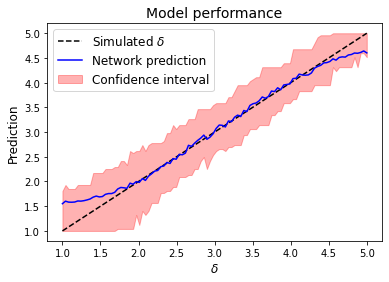

In [8]:
interval_plot(model, X_valid, Delta_vec, title = "Model performance")

In [9]:
"In case you only want the lines for your own plots"
def interval_plot_lines(model, X_valid, Delta_vec): 
    
    # Aquí ponemos el código del benchmark
    y_pred=model.predict(X_valid)
    
    n_blocks=int(np.floor(y_pred.shape[0]/100)) 
    # numero de bloques, siendo un bloque las predicciones para todo el dominio
    # de deltas
    
    
    
    y_pred_product=y_pred[:100,:]**(1/n_blocks) # Los productos
    
    
    
    for i in range(n_blocks-1):
        y_pred_product=y_pred_product*y_pred[(i+1)*100:(i+1)*100+100,:]**(1/n_blocks)
    
    for ii in range(y_pred_product.shape[0]):
        y_pred_product[ii,:]=y_pred_product[ii,:]/(np.sum(y_pred_product[ii,:]))
    
    # Ahora sacamos las lineas de la predicción y del intervalo de confianza
    Delta_upper=np.zeros(100)
    Delta_mid=np.zeros(100)
    Delta_lower=np.zeros(100)
    
    for i in range(100):
        arr=y_pred_product[i,:]
        max_h=np.amax(arr)
        pos_arr=np.where(arr>max_h/2)
        Delta_lower[i]=Delta_vec[pos_arr[0][0]]# Tengo que poner un [0] delante para indicar que quiero sacar un elemento de un
        Delta_upper[i]=Delta_vec[pos_arr[0][-1]] # array. Personalmente, npi del sentido
    
    for ii in range(100):
        Delta_mid[ii]=np.sum(y_pred_product[ii,:]*Delta_vec[:])
        
    return Delta_upper, Delta_mid, Delta_lower